Sales forecasting plays an integral role in setting expectations and making plans for your business. It’s your best shot at predicting the future. Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. 

I will be performing an exhaustive analysis in order to gain insights and engineer features with an interactive exploratory analysis and finally will use XGB to predict. 

### Importing Dependencies

In [341]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

import datetime
import math
import calendar

# Thanks for providing this in the forum
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

### **Importing Data**

In [104]:
train = pd.read_csv('rossmann-store-sales/train.csv')
test = pd.read_csv('rossmann-store-sales/test.csv')
store = pd.read_csv('rossmann-store-sales/store.csv')

train.shape, test.shape, store.shape

((1017209, 9), (41088, 8), (1115, 10))

### Joining

In [105]:
#Sanity check our train data contains all stores
train.Store.nunique(), train.Store.nunique() == store.Store.nunique()

(1115, True)

In [106]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [107]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [108]:
#Look at the train, test time periods
print("Train Period",train['Date'].min(),train['Date'].max())
print("Test Period", test['Date'].min(), test['Date'].max())

Train Period 2013-01-01 2015-07-31
Test Period 2015-08-01 2015-09-17


In [109]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [110]:
df = train.merge(store, how='left', on='Store')
df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


### Understanding the Data

In [111]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Store,1017209.0,558.43,321.91,1.0,280.0,558.0,838.0,1115.0
DayOfWeek,1017209.0,4.00,2.00,1.0,2.0,4.0,6.0,7.0
Sales,1017209.0,5773.82,3849.93,0.0,3727.0,5744.0,7856.0,41551.0
Customers,1017209.0,633.15,464.41,0.0,405.0,609.0,837.0,7388.0
Open,1017209.0,0.83,0.38,0.0,1.0,1.0,1.0,1.0
Promo,1017209.0,0.38,0.49,0.0,0.0,0.0,1.0,1.0
SchoolHoliday,1017209.0,0.18,0.38,0.0,0.0,0.0,0.0,1.0
CompetitionDistance,1014567.0,5430.09,7715.32,20.0,710.0,2330.0,6890.0,75860.0
CompetitionOpenSinceMonth,693861.0,7.22,3.21,1.0,4.0,8.0,10.0,12.0
CompetitionOpenSinceYear,693861.0,2008.69,5.99,1900.0,2006.0,2010.0,2013.0,2015.0


There are in total 1115 stores with sales feature having 3849.93 volatility and feature customers having 464.41 volatility with a mean of 57773.82 and 633.15 respectively.

In [112]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [113]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 11)

There are no duplicates and Testing dataset has 11 null values.

In [114]:
print("Training data starts from: {}".format(train.Date.min()))
print("Training data end on: {}".format(train.Date.max()))
print()
print("Testing data starts from: {}".format(test.Date.min()))
print("Testing data end on: {}".format(test.Date.max()))

Training data starts from: 2013-01-01
Training data end on: 2015-07-31

Testing data starts from: 2015-08-01
Testing data end on: 2015-09-17


### **Exploratory Data Analysis**

In [115]:
df.Date = pd.to_datetime(df.Date)
df['Day'] = df.Date.dt.day
df['Month'] = df.Date.dt.month
df['Year'] = df.Date.dt.year

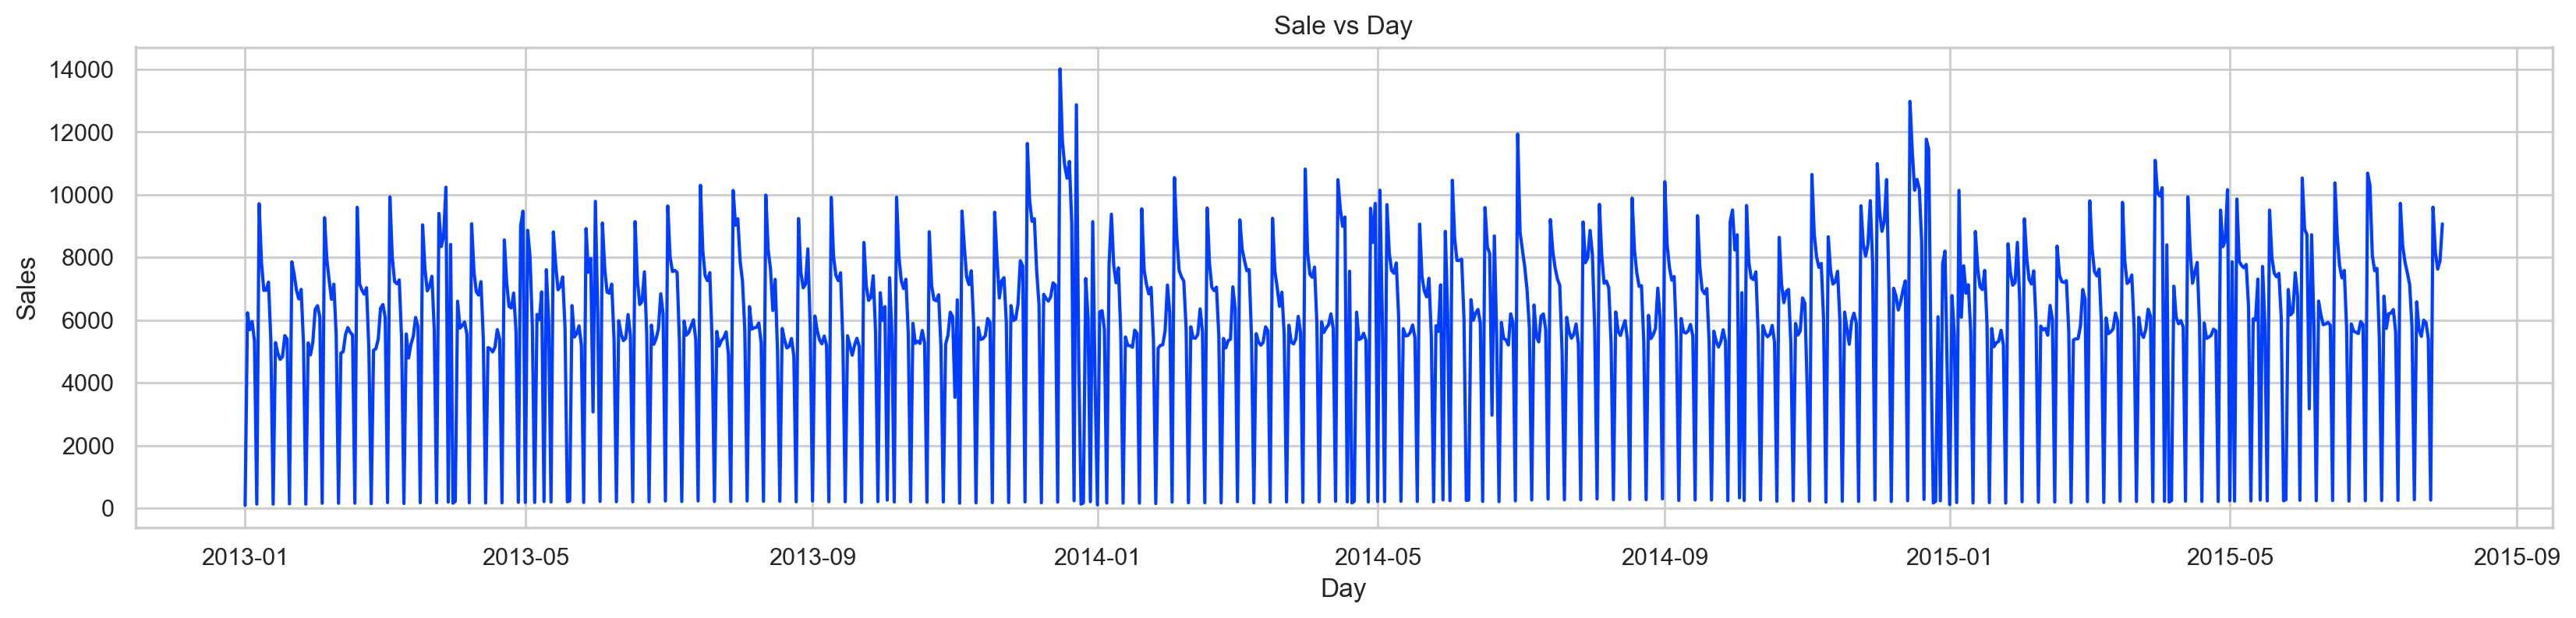

In [116]:
sns.set(style='whitegrid', palette='bright')
plt.figure(figsize=(20,4),dpi=200)
data = df.groupby('Date')['Sales'].mean().reset_index()
sns.lineplot(data = data, x='Date', y='Sales')
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

I wish to explore seasonality and trend in the dataset and somehow engineer and pre-process features with the analysis I perform.

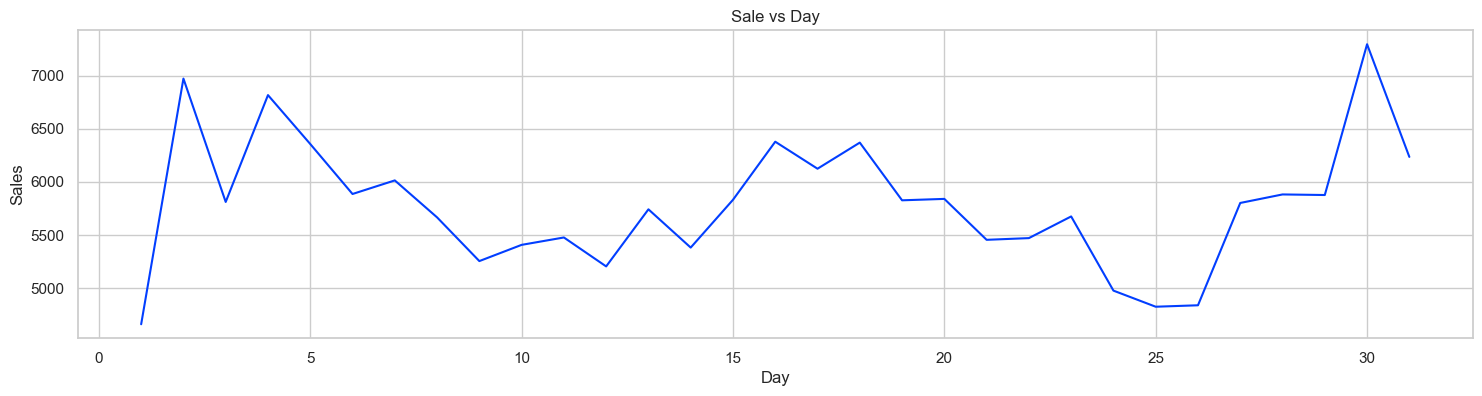

In [117]:
sns.set(style='whitegrid', palette='bright')
plt.figure(figsize=(18,4))
data = df.groupby('Day')['Sales'].mean().reset_index()
sns.lineplot(data = data, x='Day', y='Sales')
plt.title("Sale vs Day")
plt.xlabel('Day')
plt.ylabel('Sales')
plt.show()

Most Sales are done in the beginning of the month with end of the month being the lowest. 

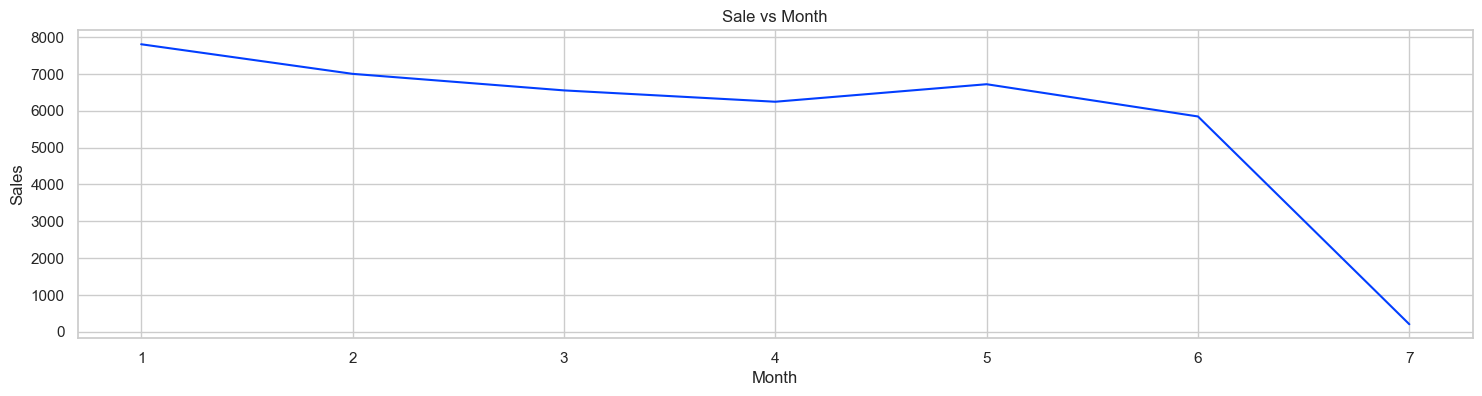

In [118]:
plt.figure(figsize=(18,4))
data = df.groupby(df['DayOfWeek'])['Sales'].mean().reset_index()
sns.lineplot(data = data, x='DayOfWeek', y='Sales')
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

Sales are more in the beginning of the week than the end. 

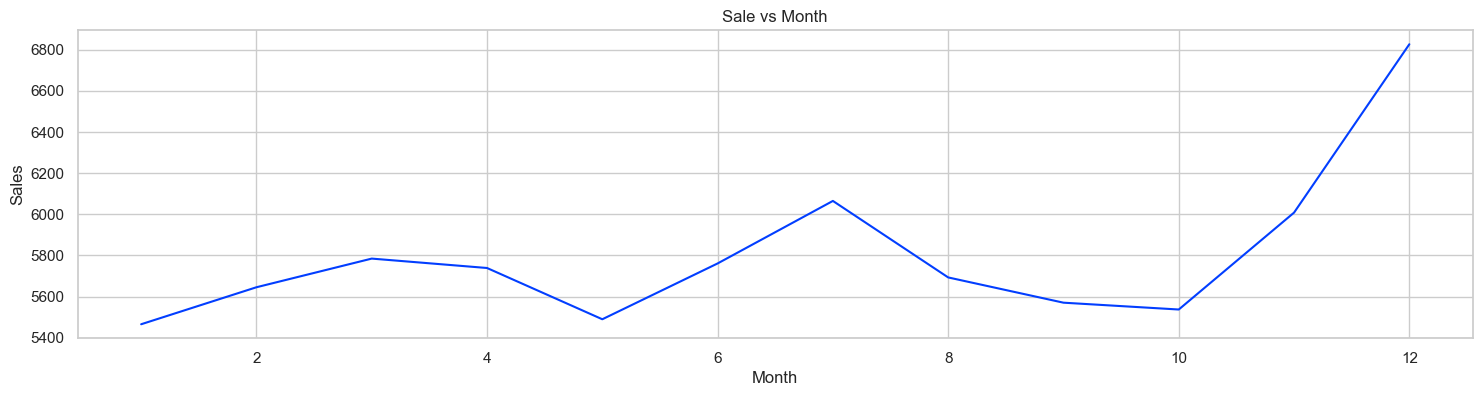

In [119]:
plt.figure(figsize=(18,4))
data = df.groupby(df['Month'])['Sales'].mean().reset_index()
sns.lineplot(data = data, x='Month', y='Sales')
plt.title("Sale vs Month")
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

Sales are relatively are higher by the end of year. 

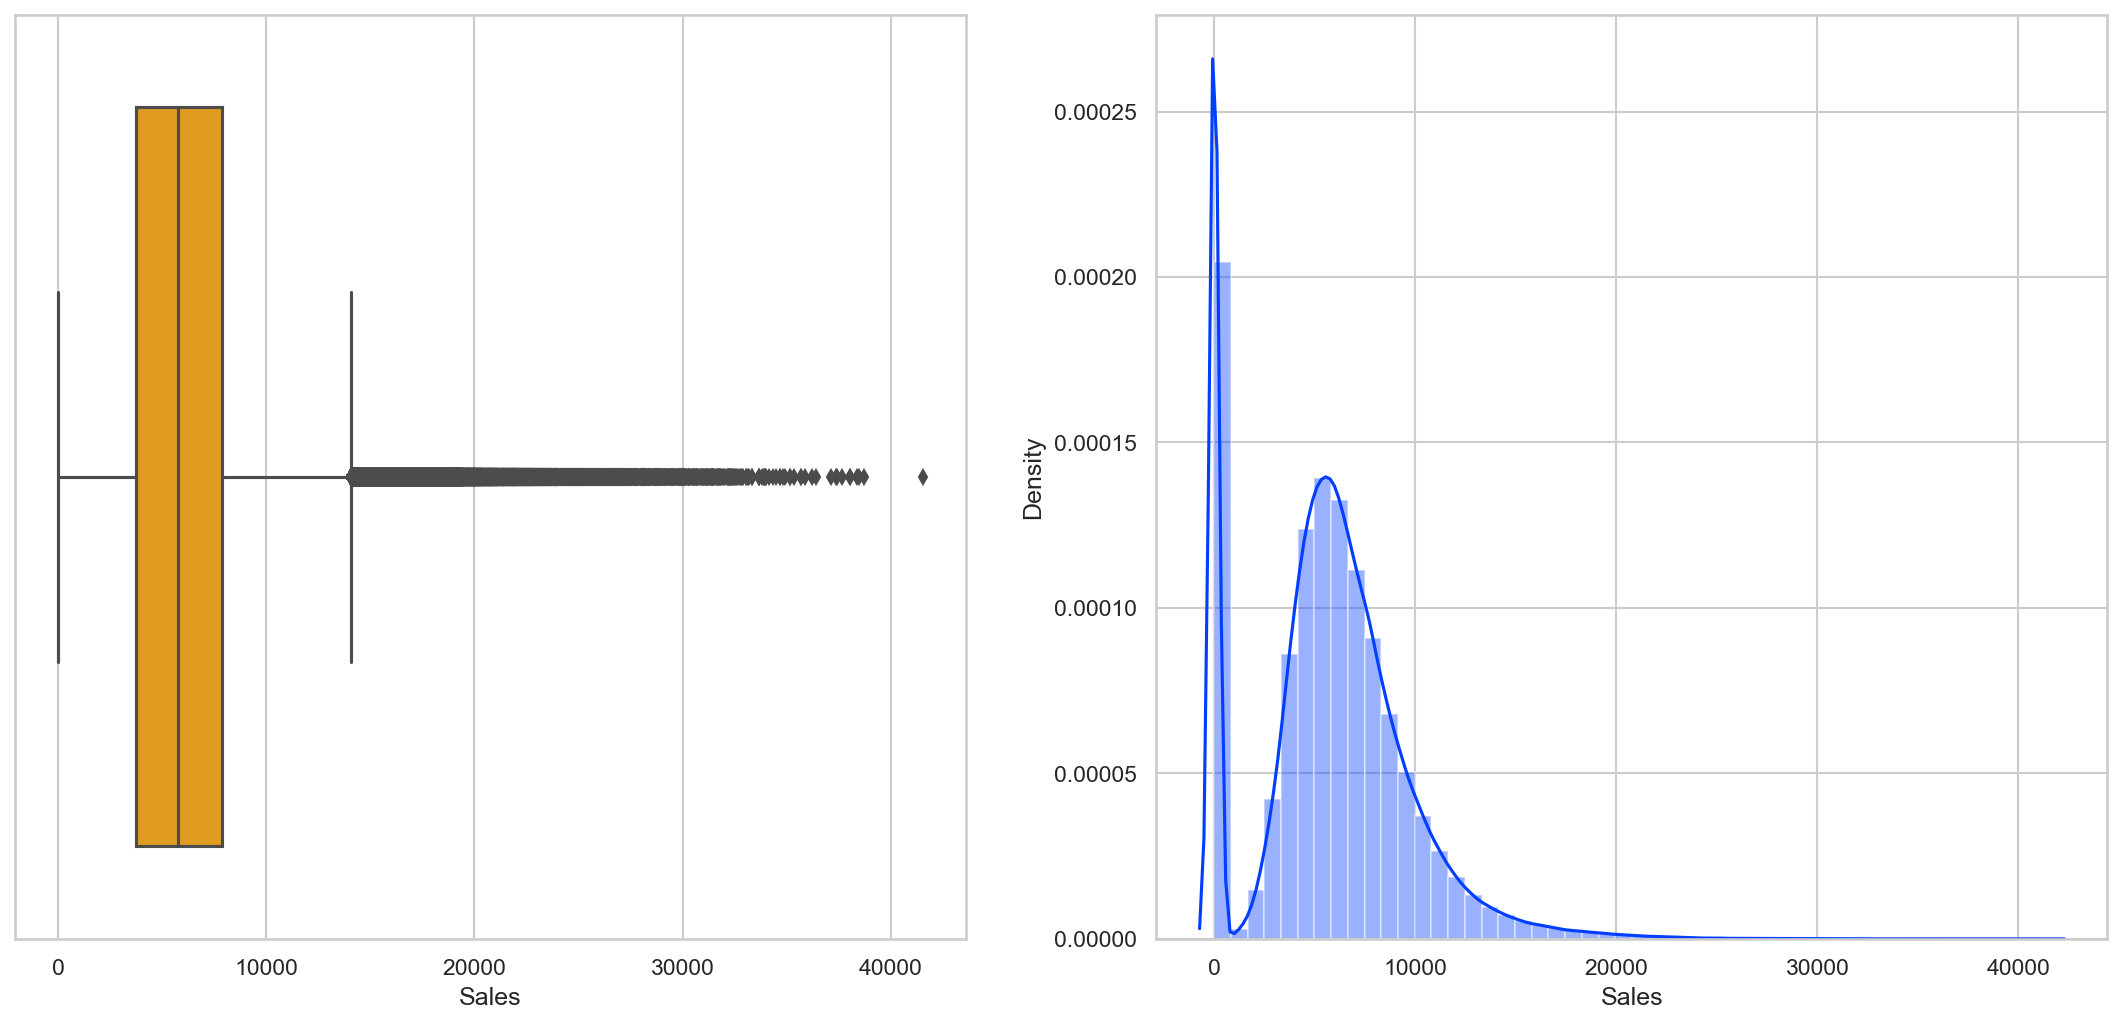

In [120]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8), dpi=150)
sns.boxplot(train['Sales'], ax=ax1, color='orange')
sns.distplot(train['Sales'], ax=ax2)
plt.show()

Sales are 0 on a huge amount of days which could mean this is either imputed to fill gaps as it doesn't make sense for sale of a day to be 0. It could mean the store was closed, maybe there was a holiday. Lets see if this stands. 

In [121]:
df[df.Open==0].Sales.value_counts()

0    172817
Name: Sales, dtype: int64

Seems like I was right! 172817 values are filled with 0. I will fill these values with np.NaN as some models like XGBoost can handle missing values and it might benifit from it. 

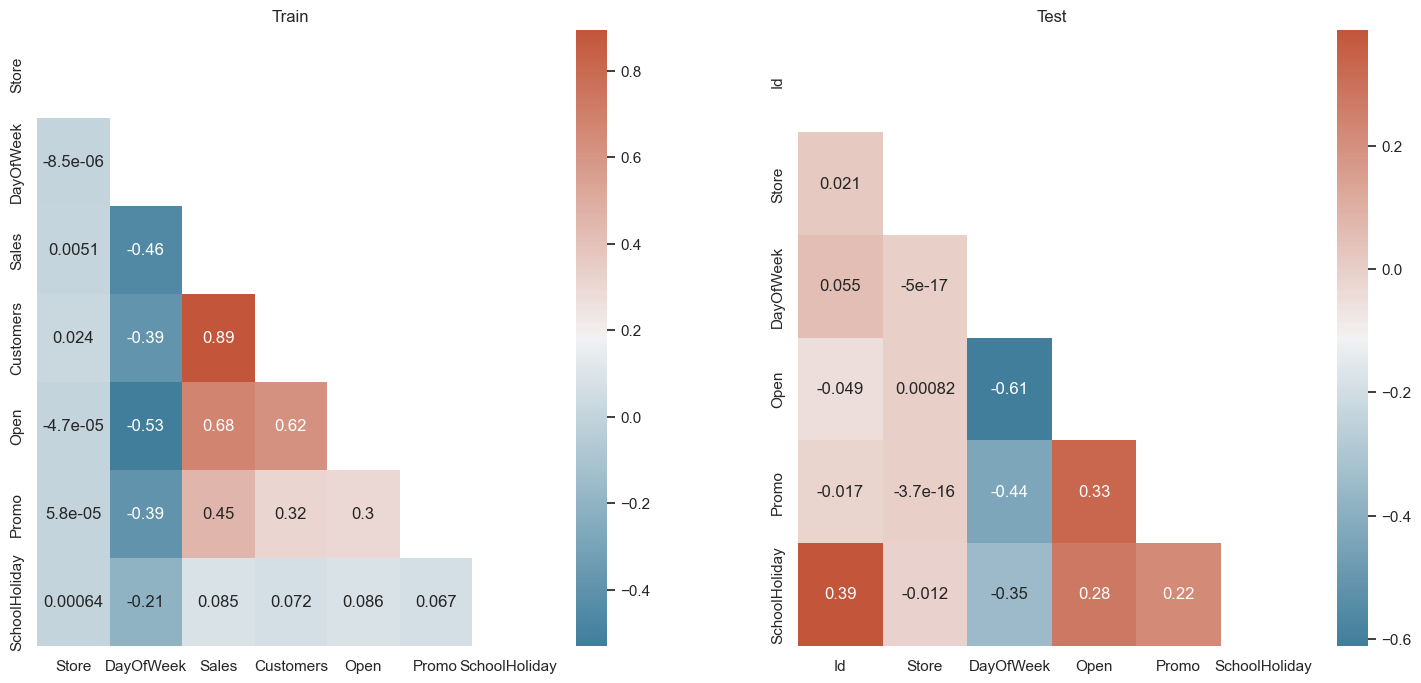

In [122]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(train.corr(), mask=mask, cmap=cmap, annot=True, ax=ax1)
ax1.set_title('Train')
corr = test.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(test.corr(), mask=mask, cmap=cmap, annot=True, ax=ax2)
ax2.set_title('Test')
plt.show()

Sales are highly correlated with feature Customers and feature Open and moderately correlated with Promo. Lets see some more plots about this!

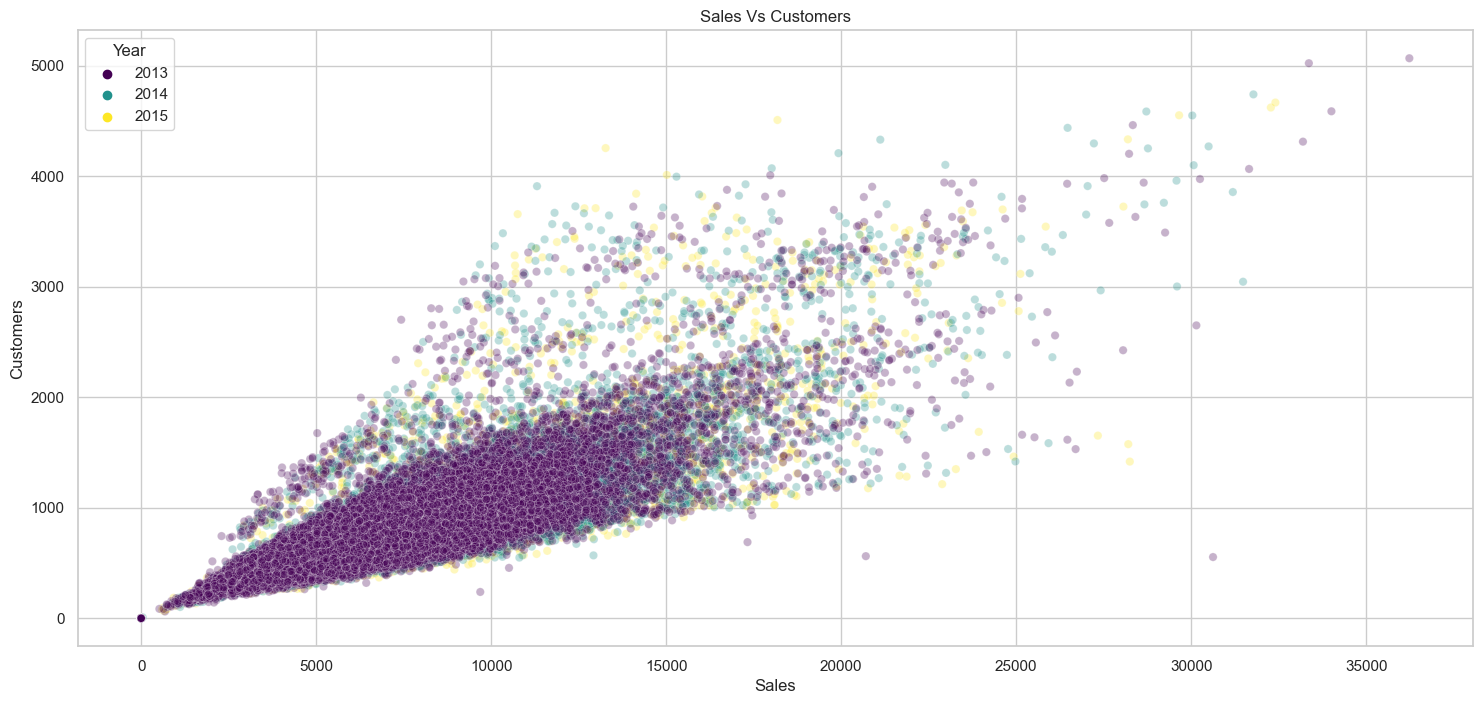

In [123]:
plt.figure(figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot(temp_df.Sales, temp_df.Customers, hue=df.Year, alpha=0.3, palette='viridis')
plt.title("Sales Vs Customers")
plt.show()

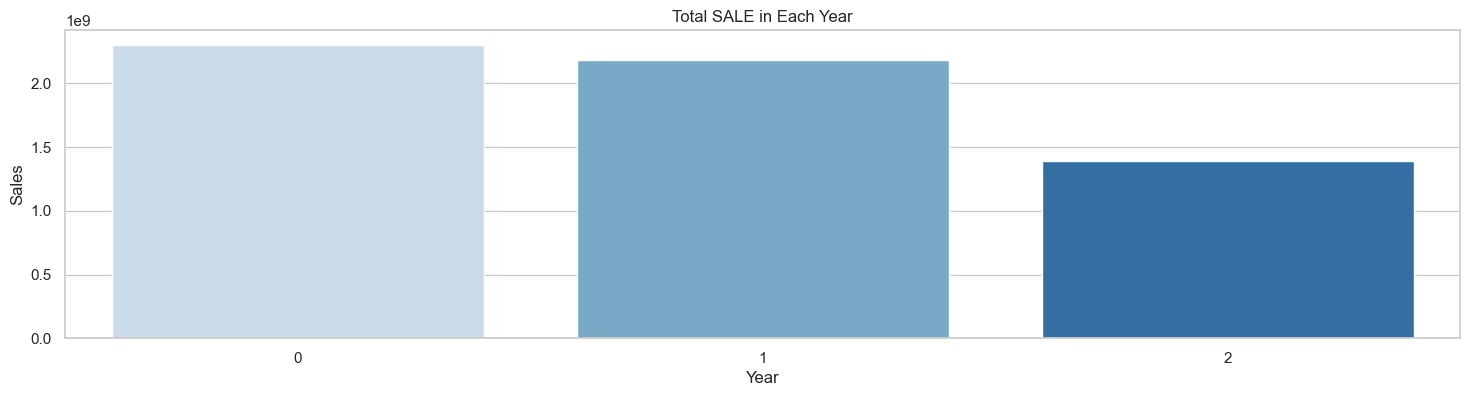

In [124]:
plt.figure(figsize=(18,4))
temp_df = df.groupby('Year')['Sales'].sum().reset_index()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Total SALE in Each Year")
plt.xlabel('Year')
plt.ylabel('Sales')
plt.show()

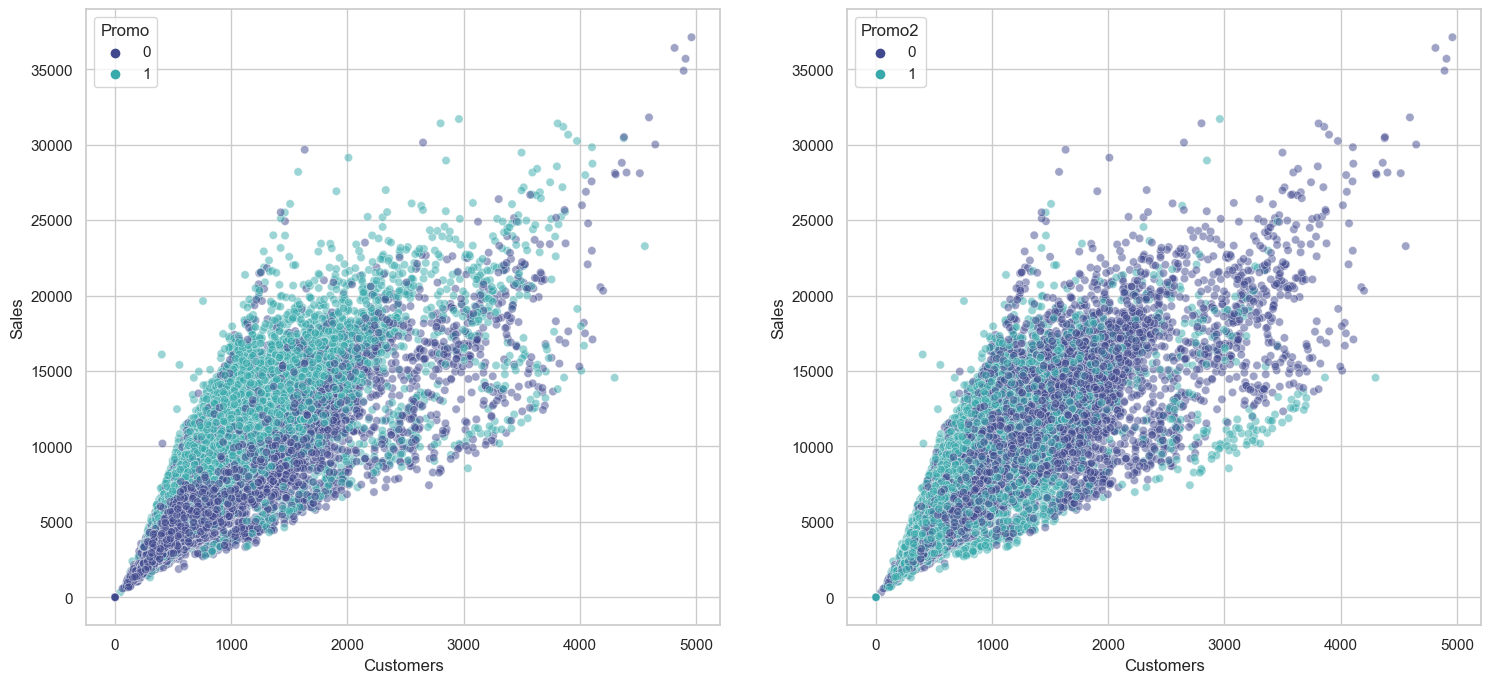

In [125]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.sample(100000)
sns.scatterplot( x=temp_df['Customers'], y=temp_df['Sales'], hue=df['Promo'],  ax=ax1, palette='mako', alpha=0.5)
sns.scatterplot( x=temp_df['Customers'], y=temp_df['Sales'], hue=df['Promo2'], ax=ax2, palette='mako', alpha=0.5)
plt.show()

Seems like Promo1 was more successful for the stores! Lets check the Sales for each promo on average. 

In [126]:
df.groupby('Promo')['Sales'].mean(), df.groupby('Promo2')['Sales'].mean() #1 means store participated


(Promo
 0    4406.050805
 1    7991.152046
 Name: Sales, dtype: float64,
 Promo2
 0    6124.710161
 1    5423.718218
 Name: Sales, dtype: float64)

Lets see if the type of store is a significant feature! Intuitively, stores inventory and ambience should be a huge factor. 

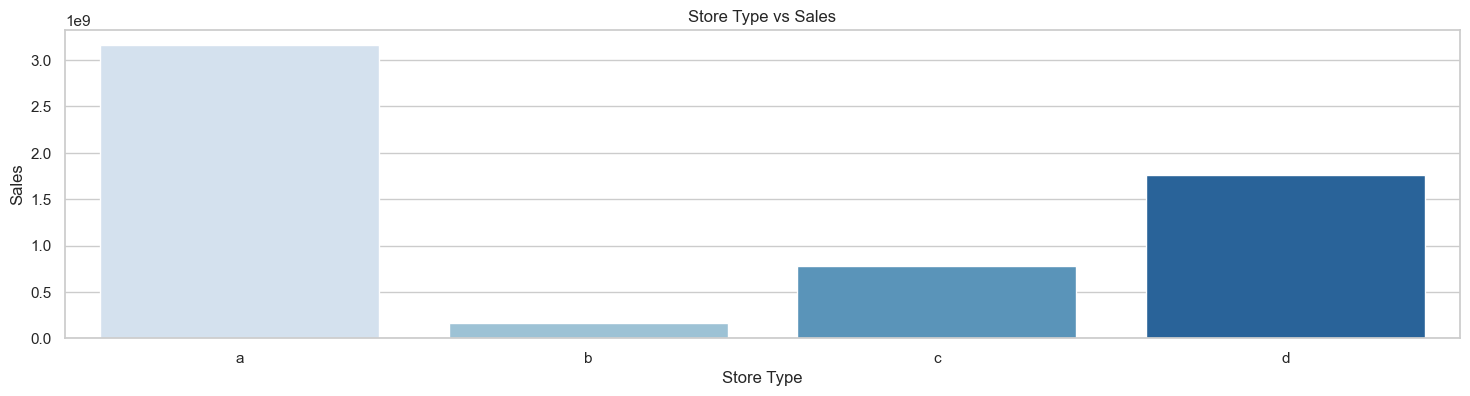

In [127]:
plt.figure(figsize=(18,4))
temp_df = df.groupby('StoreType').sum()
sns.barplot(temp_df.index, temp_df.Sales, palette='Blues')
plt.title("Store Type vs Sales")
plt.xlabel('Store Type')
plt.ylabel('Sales')
plt.show()

Why does Store A outperform all other stores?

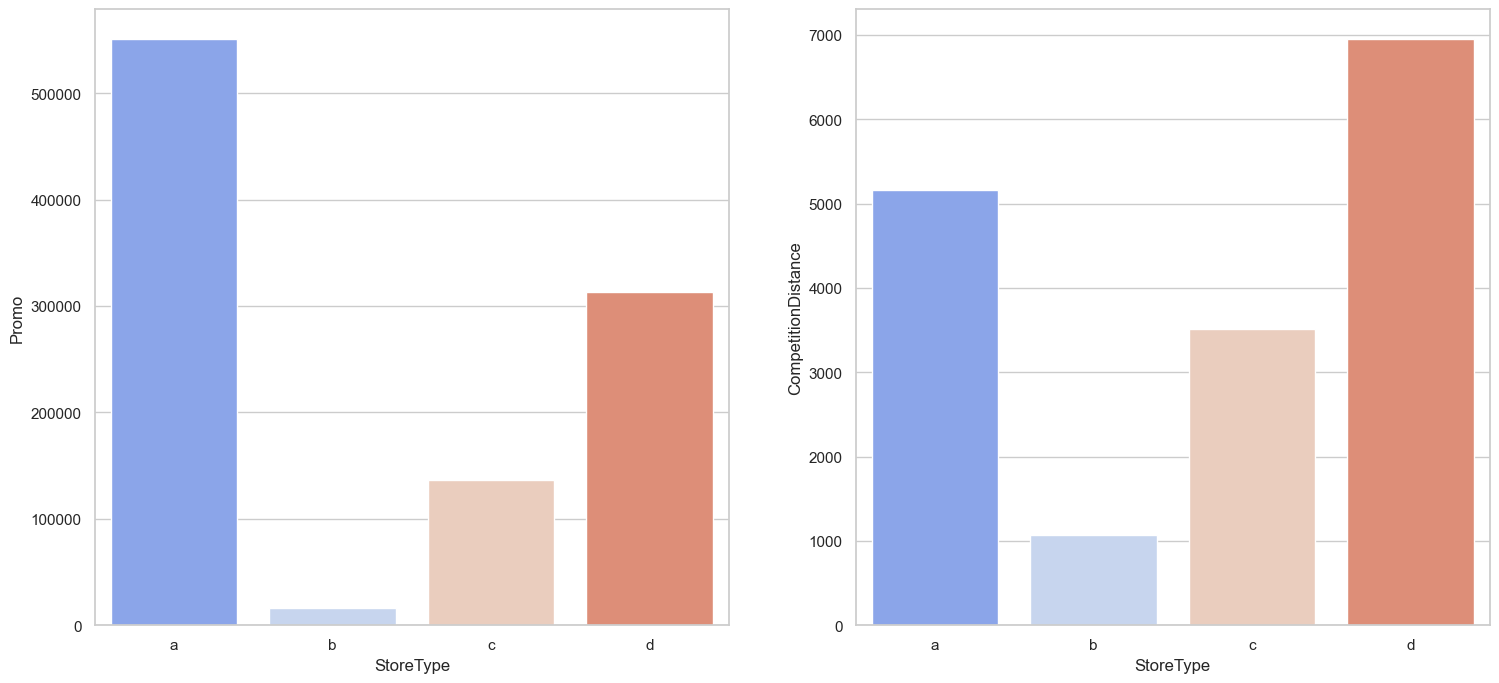

In [128]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
temp_df = df.groupby('StoreType').count()
sns.barplot(temp_df.index, temp_df['Promo'], ax=ax1, palette='coolwarm')
temp_df = df.groupby('StoreType').mean()
sns.barplot(temp_df.index, temp_df['CompetitionDistance'], ax=ax2, palette='coolwarm')
plt.show()

Store A did the most Promo'1's inspite of being on average top second in comparison to other stores with regard to Competition Distance (distance in meters to the nearest competitor store). Hence, I think it is fair to say promos are a big deal. Other factors could be seasonality, trend etc. Lets see about trend!

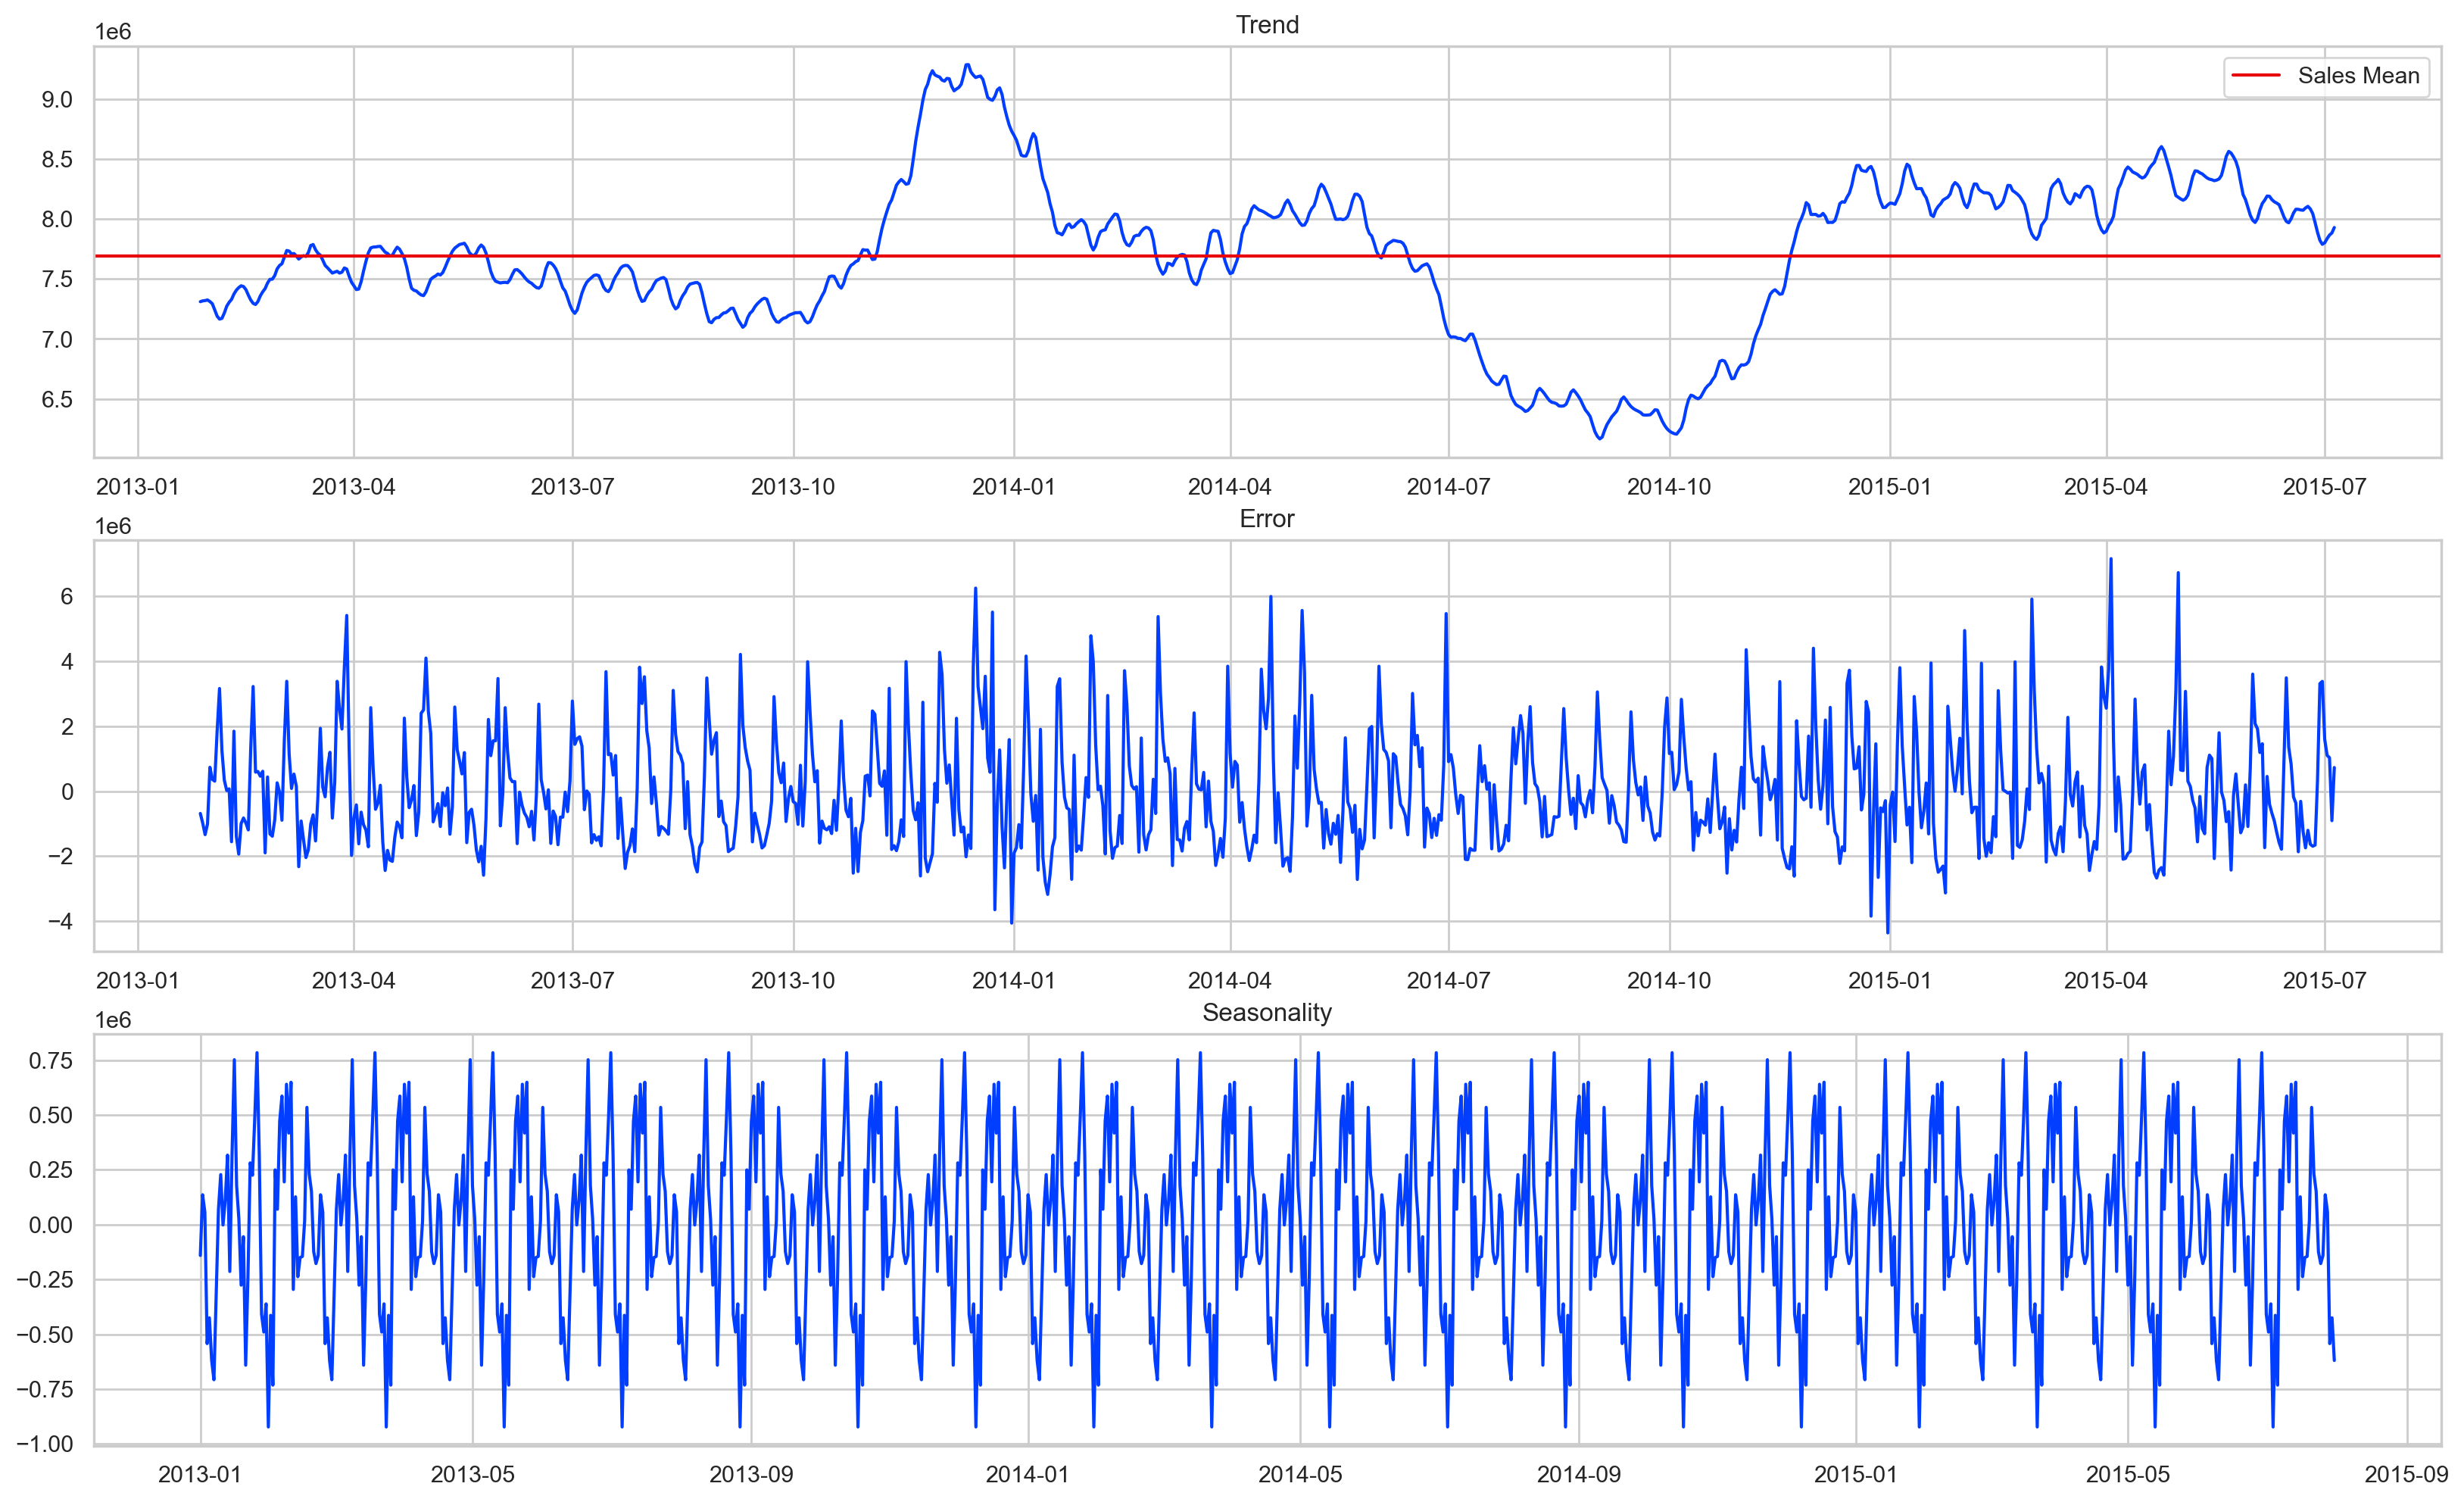

In [129]:
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = train.copy()
temp_df['Date'] = pd.to_datetime(temp_df.Date)
temp_df.index = temp_df['Date']
temp_df['Sales'] = temp_df['Sales'].apply(lambda x: None if x == 0 else x)
temp_df['Sales'] = temp_df['Sales'].fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df[['Sales']]
temp_df = temp_df.groupby(temp_df.index).sum()
result = seasonal_decompose(temp_df, model='additive', period=52)

fig, (ax1, ax2,ax3) = plt.subplots(nrows=3, ncols=1, figsize=(20,12),dpi=200)
ax1.plot(result.trend)
ax1.axhline(y = temp_df['Sales'].mean(), color = 'r', linestyle = '-', label='Sales Mean')
ax1.set_title("Trend")
ax2.plot(result.resid)
ax2.set_title("Error")
ax3.plot(result.seasonal)
ax3.set_title("Seasonality")
ax1.legend()
plt.show()

2015 has been a good year as the trend line is above the average line by the end of 2014. Beginning of 2014 is a huge peak, I wonder what drived that?

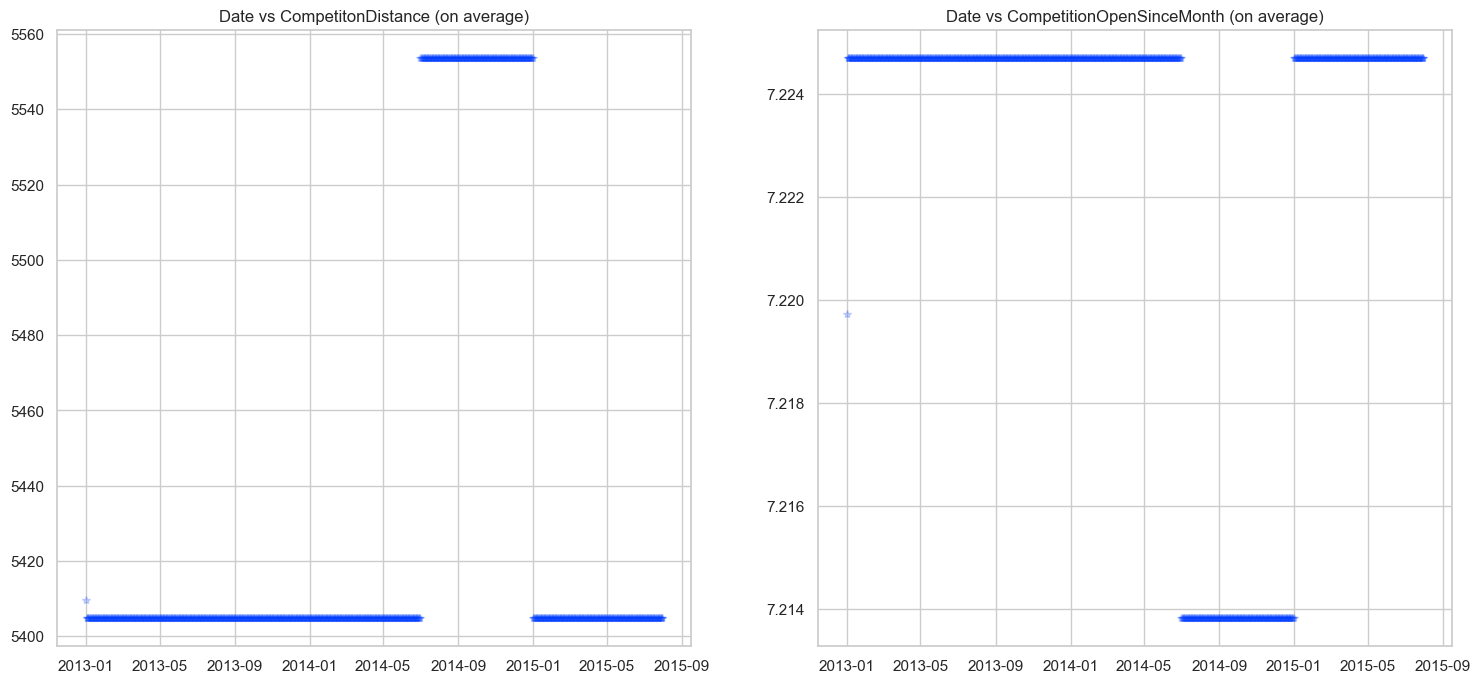

In [130]:
temp_df = df.copy()
temp_df.index = temp_df['Date']
temp_df['Sales'] = temp_df['Sales'].apply(lambda x: None if x == 0 else x)
temp_df['Sales'] = temp_df['Sales'].fillna(method='ffill').fillna(method='bfill')
temp_df = temp_df.groupby(temp_df.index).mean()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1.plot(temp_df['CompetitionDistance'], '*',alpha=0.2)
ax1.set_title("Date vs CompetitonDistance (on average)")
ax2.plot(temp_df['CompetitionOpenSinceMonth'], '*', alpha=0.2)
ax2.set_title("Date vs CompetitionOpenSinceMonth (on average)")
plt.show()

Seems like there was a new competitor near the end of 2014 and since the distance also relatively increased it could be maybe change of location but these are just assumptions. It could be useful for the model to interpret such behaviour in the future for the stores. 

I wonder if the stores had done less promos when the trend was going down. Lets see!

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,...,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Day,Month,Year
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31,1,3,2014-12-31,2605,327,1,0,0,1,c,...,1270.0,9.0,2008.0,0,NaN,NaN,NaN,31,12,2014
2014-12-31,2,3,2014-12-31,2269,252,1,0,0,1,a,...,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",31,12,2014
2014-12-31,3,3,2014-12-31,3804,408,1,0,0,1,a,...,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",31,12,2014
2014-12-31,4,3,2014-12-31,10152,1311,1,0,0,1,c,...,620.0,9.0,2009.0,0,NaN,NaN,NaN,31,12,2014
2014-12-31,5,3,2014-12-31,1830,217,1,0,0,1,a,...,29910.0,4.0,2015.0,0,NaN,NaN,NaN,31,12,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-01-01,1111,3,2014-01-01,0,0,0,0,a,1,a,...,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct",1,1,2014
2014-01-01,1112,3,2014-01-01,0,0,0,0,a,1,c,...,1880.0,4.0,2006.0,0,NaN,NaN,NaN,1,1,2014
2014-01-01,1113,3,2014-01-01,0,0,0,0,a,1,a,...,9260.0,NaN,NaN,0,NaN,NaN,NaN,1,1,2014


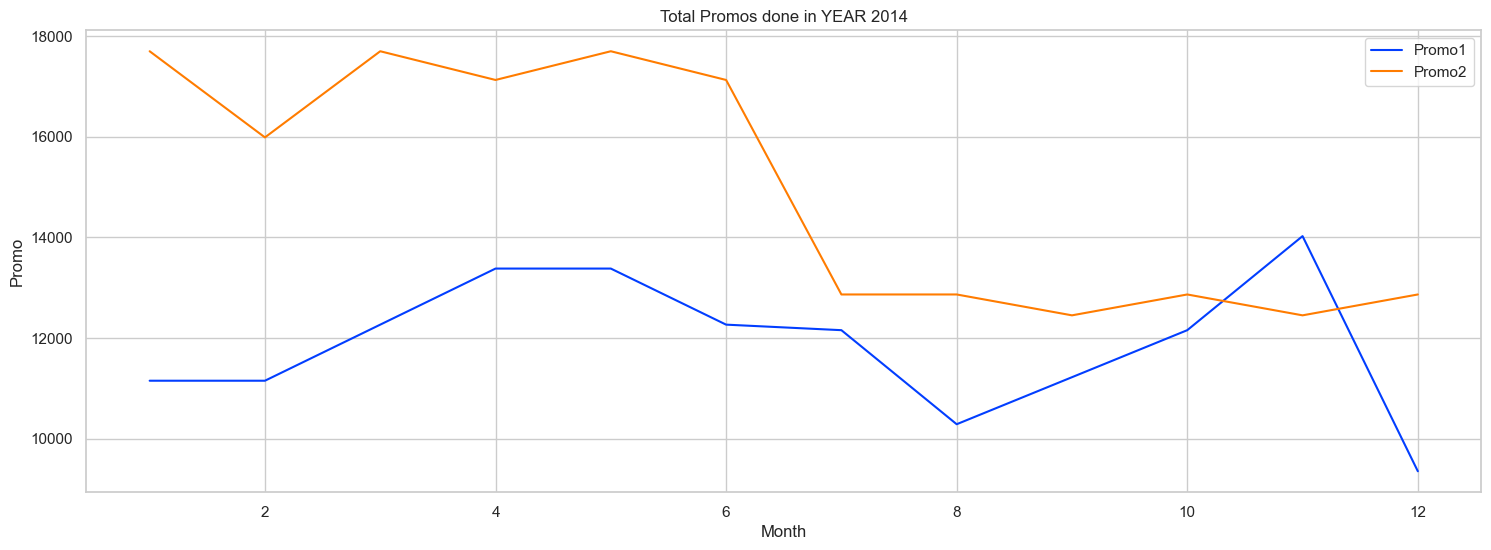

In [131]:
plt.figure(figsize=(18,6))
temp_df = df.copy()
temp_df.index = temp_df['Date']
temp_df = temp_df[temp_df['Year']==2014]
display(temp_df)
temp_df = temp_df.groupby('Month').sum()
temp_df['Sales'] = temp_df['Sales'].apply(lambda x: None if x == 0 else x)
temp_df['Sales'] = temp_df['Sales'].fillna(method='ffill').fillna(method='bfill')

plt.title('Total Promos done in YEAR 2014')
sns.lineplot(temp_df.index, temp_df['Promo'], palette='Blues', label='Promo1')
sns.lineplot(temp_df.index, temp_df['Promo2'], palette='Blues', label='Promo2')
plt.legend()
plt.show()

In [132]:
train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1


### **Feature Engineering and Preprocessing**

In [133]:
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']
train['is_train'] = 1
test['is_train'] = 0
df = pd.concat([train, test])
df['Date'] = pd.to_datetime(df['Date']) #Converting date to required format

In [136]:
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))] #Removing rows with Sales 0

Time encoding

In [138]:
var_name = 'Date'

df[var_name + 'Day'] = df[var_name].dt.day #addding day
df[var_name + 'Week'] = df[var_name].dt.week #adding week
df[var_name + 'Month'] = df[var_name].dt.month #adding month
df[var_name + 'Year'] = df[var_name].dt.year #adding year
df[var_name + 'DayOfYear'] = df[var_name].dt.dayofyear #adding dayofyear

features_x.remove(var_name) #removing Date
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

Encode Categorical features

In [137]:
df['StateHoliday'] = df['StateHoliday'].map({0:'0', 'a':'a', 'b':'b', 'c':'c', '0':'0'}) #mixed data types
df['StateHoliday'] = LabelEncoder().fit_transform(df['StateHoliday']) #Encoding for XG Boost

In [139]:
store['StoreType'] = LabelEncoder().fit_transform(store['StoreType']) #encoding StoreType
store['Assortment'] = LabelEncoder().fit_transform(store['Assortment']) #encoding Assortment

In [140]:
join_with = store['PromoInterval'].str.split(',').apply(pd.Series)
join_with.columns = join_with.columns.map(lambda x: str(x) + '_PromoInterval')
store = store.join(join_with) #joining splits

In [141]:
def monthToNum(value):
    if(value=='Sept'):
        value='Sep'
    return list(calendar.month_abbr).index(value)
#mapping month abbr to month number
store['0_PromoInterval'] = store['0_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['1_PromoInterval'] = store['1_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['2_PromoInterval'] = store['2_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['3_PromoInterval'] = store['3_PromoInterval'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)

In [142]:
competition_open = []
for index, value in store[['CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']].iterrows():
    try:
        year, month = int(value['CompetitionOpenSinceYear']), int(value['CompetitionOpenSinceMonth'])
        date = pd.to_datetime("{}-{}-01".format(year, month), format='%Y-%m')
        competition_open.append(date)
    except:
        competition_open.append(np.nan)
competition_open = pd.Series(competition_open)
competition_open.shape

(1115,)

In [143]:
store['CompetitionOpen'] = competition_open #converted int to datetime
store['CompetitionOpen'] = store.CompetitionOpen.dt.strftime('%Y%m%d')

In [144]:
promo = []
for index, value in store[['Promo2SinceWeek', 'Promo2SinceYear']].iterrows():
    try:
        year, week = int(value['Promo2SinceYear']), int(value['Promo2SinceWeek'])
        date = pd.to_datetime("{}-{}-01".format(year, week), format='%Y%W')
        promo.append(date)
    except:
        promo.append(np.nan)
promo = pd.to_datetime(pd.Series(competition_open))
promo.shape

(1115,)

In [145]:
store['PromoSince'] = promo #converted int to datetime
store['PromoSince'] = store.PromoSince.dt.strftime('%Y%m%d')

In [146]:
store_features = ['Store', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpen', 
                  'PromoSince', '0_PromoInterval']
#1_PromoInterval, 2_PromoInterval, 3_PromoInterval irrelevent

In [147]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [148]:
features_x = list(set(features_x + store_features))

In [149]:
for feature in features_x:
    df[feature] = df[feature].fillna(-999) #out of range value for model

In [150]:
df['DateInt'] = df.Date.dt.strftime('%Y%m%d').map(int) #mapping to Int
df['CompetitionOpen'] = df.CompetitionOpen.map(int)
df['PromoSince'] = df.PromoSince.map(int)

In [151]:
df['Zscore'] = (df.Sales - df.Sales.mean())/df.Sales.std()

In [152]:
thresh=4.0
def check_outlier(value):
    if(value>=thresh):
        return True
    else:
        return False

df['Outlier'] = df.Zscore.apply(check_outlier)

How much does each store sales generally?

In [153]:
store_data_sales = df.groupby([df['Store']])['Sales'].sum()
store_data_customers = df.groupby([df['Store']])['Customers'].sum()
store_data_open = df.groupby([df['Store']])['Open'].count()

store_data_sales_per_day = store_data_sales / store_data_open
store_data_customers_per_day = store_data_customers / store_data_open
store_data_sales_per_customer_per_day = store_data_sales_per_day / store_data_customers_per_day

df_store = pd.merge(store, store_data_sales_per_day.reset_index(name='SalesPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_customers_per_day.reset_index(name='CustomersPerDay'), how='left', on=['Store'])
df_store = pd.merge(df_store, store_data_sales_per_customer_per_day.reset_index(name='SalesPerCustomersPerDay'), how='left', on=['Store'])

In [154]:
store_features = ['Store', 'SalesPerDay', 'CustomersPerDay', 'SalesPerCustomersPerDay']

features_x = list(set(features_x + store_features))
df = pd.merge(df, df_store[store_features], how='left', on=['Store'])

In [155]:
holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().StateHoliday
df = pd.merge(df, holidays_each_day_of_week.reset_index(name='HolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [156]:
school_holidays_each_day_of_week = df.groupby(df.DayOfWeek).sum().SchoolHoliday
df = pd.merge(df, school_holidays_each_day_of_week.reset_index(name='SchoolHolidaysPerDayOfWeek'), on=['DayOfWeek'])

In [157]:
promo_each_day_of_week = df.groupby(df.DayOfWeek).sum().Promo
df = pd.merge(df, promo_each_day_of_week.reset_index(name='PromoPerDayOfWeek'), on=['DayOfWeek'])

Is holidays passing or coming?

In [342]:

holidays_next_week=[]
holidays_next_week_index=[]
for index, value in tqdm(df.groupby('Date').sum().iterrows()):
    start_range = index + datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=15)
    school_holidays = sum((df.groupby('Date').sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby('Date').sum()[start_range:end_range]).StateHoliday)
    holidays_next_week.append(school_holidays+state_holidays)
    holidays_next_week_index.append(index)
    
holidays_next_week = pd.Series(holidays_next_week)
holidays_next_week.shape

0it [00:00, ?it/s]

(990,)

In [343]:
holidays_this_week=[]
index_list = []
for index, value in tqdm(df.groupby(df.Date).sum().iterrows()):
    start_range = index 
    end_range = index + datetime.timedelta(days=7)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_this_week.append(school_holidays+state_holidays)
    index_list.append(index)
    
holidays_this_week = pd.Series(holidays_this_week)
holidays_this_week.shape

0it [00:00, ?it/s]

(990,)

In [344]:
holidays_last_week=[]
holidays_last_week_index=[]
for index, value in tqdm(df.groupby(df.Date).sum().iterrows()):
    start_range = index - datetime.timedelta(days=7)
    end_range = index + datetime.timedelta(days=1)
    school_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).SchoolHoliday)
    state_holidays = sum((df.groupby(df.Date).sum()[start_range:end_range]).StateHoliday)
    holidays_last_week.append(school_holidays+state_holidays)
    holidays_last_week_index.append(index)
    
holidays_last_week = pd.Series(holidays_next_week)
holidays_last_week.shape

0it [00:00, ?it/s]

(990,)

In [345]:
temp_df = pd.DataFrame({'HolidaysNextWeek':holidays_next_week, 'Date': holidays_next_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [346]:
temp_df = pd.DataFrame({'HolidaysThisWeek':holidays_this_week, 'Date': index_list})
df = pd.merge(df, temp_df, on=['Date'])

In [347]:
temp_df = pd.DataFrame({'HolidaysLastWeek':holidays_last_week, 'Date': holidays_last_week_index})
df = pd.merge(df, temp_df, on=['Date'])

In [348]:
holidays_features = ['HolidaysPerDayOfWeek', 'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek', 
                     'HolidaysNextWeek', 'HolidaysThisWeek', 'HolidaysLastWeek']

features_x = list(set(features_x + holidays_features))

In [349]:
#Most Promos are done on DayofWeek 4
df['DaysTillMaxPromo'] = df.DayOfWeek.apply(lambda x: 4-x)

In [350]:
df['PromoTomorrow'] = df.Promo.shift(-1)
df['PromoYesterday'] = df.Promo.shift(1)

In [351]:
promo_features = ['DaysTillMaxPromo', 'PromoTomorrow', 'PromoYesterday']

features_x = list(set(features_x + promo_features))

In [352]:
df.Sales = df.Sales.apply(lambda x: np.nan if x == 0 else x) #Convert 0 to NaNs

In [353]:
df.loc[df['is_train'] == 1, 'SalesLog'] = np.log(1+df.loc[df['is_train'] == 1]['Sales']) #Transforming Sales to 1+log

In [359]:
len(features_x), df.shape, df.isnull().sum().sum()

(29, (1058243, 38), 1527143)

In [357]:
features_x

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'is_train', 'Id', 'DateDay',
       'DateWeek', 'DateMonth', 'DateYear', 'DateDayOfYear', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpen', 'PromoSince',
       '0_PromoInterval', 'DateInt', 'Zscore', 'Outlier', 'SalesPerDay',
       'CustomersPerDay', 'SalesPerCustomersPerDay', 'HolidaysPerDayOfWeek',
       'SchoolHolidaysPerDayOfWeek', 'PromoPerDayOfWeek', 'DaysTillMaxPromo',
       'PromoTomorrow', 'PromoYesterday', 'SalesLog', 'HolidaysNextWeek',
       'HolidaysThisWeek', 'HolidaysLastWeek'],
      dtype='object')

# **Modelling**

## **XGBoost** 

In [358]:
import xgboost as xgb

In [360]:
data = df.loc[(df['is_train'] == 1) & (df['Open'] == 1) & (df['Outlier'] == False)]
x_train, x_test, y_train, y_test = train_test_split(data[features_x], 
                                                    data[features_y], 
                                                    test_size=0.1, 
                                                    random_state=42)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test, y_test)

num_round = 5000
evallist = [(dtrain, 'train'), (dtest, 'test')]

param = {'max_depth': 9,
         'eta': 0.01,
         'subsample': 0.75,
         'colsample_bytree': 0.6, 
         'objective': 'reg:squarederror',}

plst = list(param.items())

model = xgb.train(plst, dtrain, num_round, evallist, 
                  feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

(757442, 29) (757442, 1) (84161, 29) (84161, 1)
[0]	train-rmse:8.18186	train-rmspe:0.99986	test-rmse:8.17801	test-rmspe:0.99986
[250]	train-rmse:0.68243	train-rmspe:0.49260	test-rmse:0.68183	test-rmspe:0.48641
[500]	train-rmse:0.14260	train-rmspe:0.19485	test-rmse:0.14347	test-rmspe:0.14644
[750]	train-rmse:0.12075	train-rmspe:0.17627	test-rmse:0.12259	test-rmspe:0.13473
[1000]	train-rmse:0.11401	train-rmspe:0.16450	test-rmse:0.11651	test-rmspe:0.12836
[1250]	train-rmse:0.10979	train-rmspe:0.15607	test-rmse:0.11284	test-rmspe:0.12430
[1500]	train-rmse:0.10614	train-rmspe:0.14892	test-rmse:0.10970	test-rmspe:0.12089
[1750]	train-rmse:0.10312	train-rmspe:0.14488	test-rmse:0.10717	test-rmspe:0.11809
[2000]	train-rmse:0.10049	train-rmspe:0.13936	test-rmse:0.10503	test-rmspe:0.11580
[2250]	train-rmse:0.09832	train-rmspe:0.13597	test-rmse:0.10333	test-rmspe:0.11399
[2500]	train-rmse:0.09631	train-rmspe:0.13127	test-rmse:0.10179	test-rmspe:0.11232
[2750]	train-rmse:0.09446	train-rmspe:0.12718

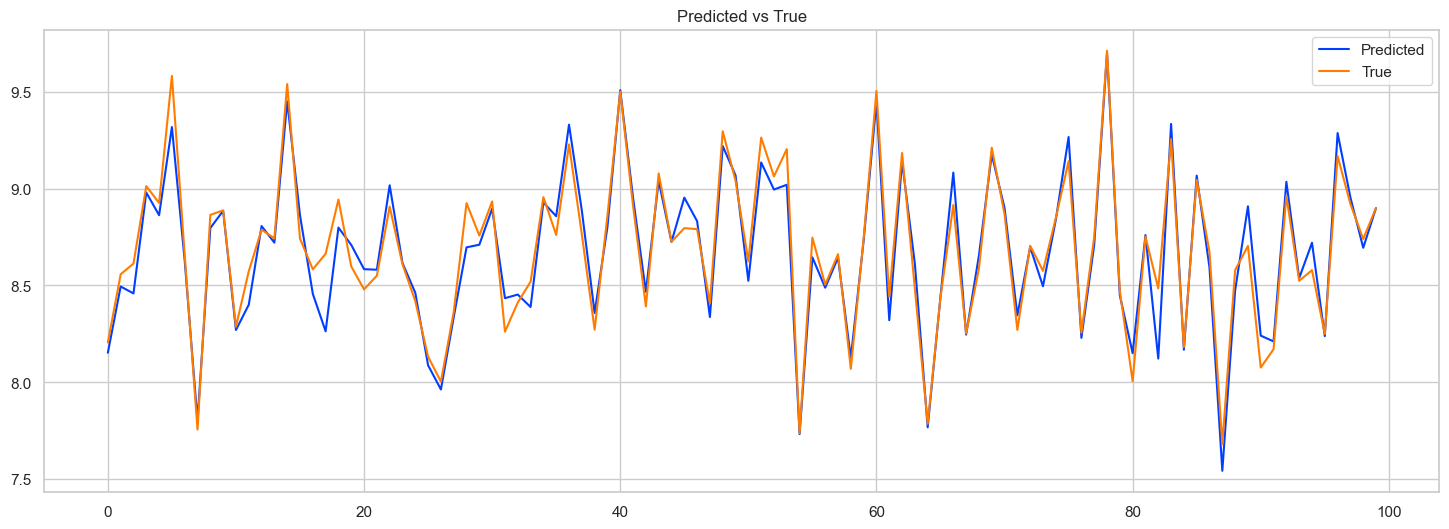

In [372]:
y_pred = model.predict(dtest)[:100]
y_true = y_test.iloc[:100].reset_index(drop=True)
plt.figure(figsize=(18,6))
plt.plot(y_pred, label='Predicted')
plt.plot(y_true, label='True')
plt.title("Predicted vs True")
plt.legend()
plt.show()

<Figure size 3600x1600 with 0 Axes>

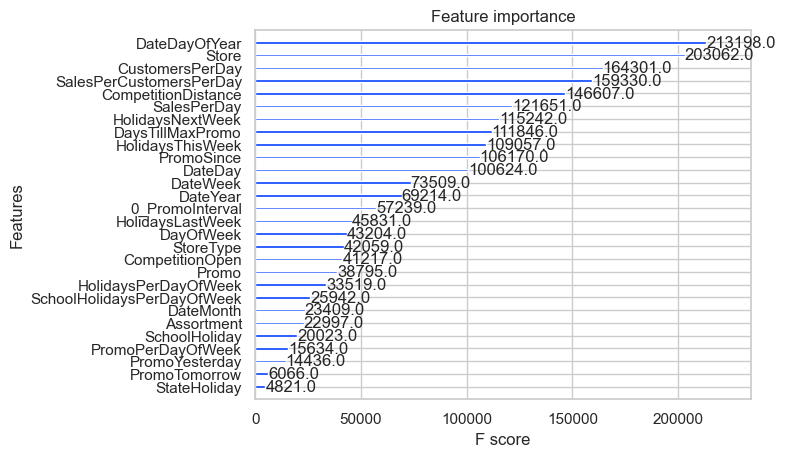

In [362]:
#Print Feature Importance
plt.figure(figsize=(18,8),dpi=200)
from xgboost import plot_importance
plot_importance(model)
plt.show()

In [373]:
submit = df.loc[df['is_train'] == 0]
dsubmit = xgb.DMatrix(submit[features_x])
predictions = model.predict(dsubmit)

df_predictions = submit['Id'].reset_index()
df_predictions['Id'] = df_predictions['Id'].astype('int')
df_predictions['Sales'] = (np.exp(predictions) - 1) * 0.985 #Scale Back

df_predictions.sort_values('Id', inplace=True)
df_predictions[['Id', 'Sales']].to_csv('solution.csv', index=False)
df_predictions

,index,Id,Sales
5136,296801,1,4188.952148
5137,296802,2,7412.845703
5138,296803,3,8899.125000
5139,296804,4,7194.057617
5140,296805,5,7126.202148
...,...,...,...
41083,1058238,41084,2615.318115
41084,1058239,41085,7507.866699
41085,1058240,41086,6218.428711
41086,1058241,41087,20457.839844


## **Arima Models**

In [174]:
# !pip install pmdarima -q

In [175]:
from statsmodels.tsa.stattools import adfuller # Augmented Dickey Fuller test for testing stationarity
from statsmodels.tsa.arima_model import ARIMA #for manual ARIMA
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf #autocorrelation plot
from pandas.plotting import autocorrelation_plot #autocorrelation plot
from statsmodels.graphics.gofplots import qqplot #residual diagnostics
import pmdarima as pm #auto arima

In [245]:
df_ts_train = df[df['is_train'] == 1].sort_values(['Store', 'Date']).iloc[:-200]
df_ts_val = df[df['is_train'] == 1].sort_values(['Store', 'Date']).iloc[-200:]
print(df_ts_train.shape, df_ts_val.shape)
df_ts_val

(1016955, 35) (200, 35)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,is_train,...,SalesPerDay,CustomersPerDay,SalesPerCustomersPerDay,HolidaysPerDayOfWeek,SchoolHolidaysPerDayOfWeek,PromoPerDayOfWeek,DaysTillMaxPromo,PromoTomorrow,PromoYesterday,SalesLog
486770,1115,2,2015-01-13,6134.0,424.0,1.0,1,0,0,1,...,4971.948485,341.29697,14.567807,1423,40126,81000,2,1.0,1.0,8.721765
335127,1115,3,2015-01-14,5491.0,396.0,1.0,1,0,0,1,...,4971.948485,341.29697,14.567807,5725,37879,80998,1,1.0,1.0,8.611048
183306,1115,4,2015-01-15,6359.0,428.0,1.0,1,0,0,1,...,4971.948485,341.29697,14.567807,15449,37938,80997,0,1.0,1.0,8.757784
32333,1115,5,2015-01-16,7720.0,497.0,1.0,1,0,0,1,...,4971.948485,341.29697,14.567807,12291,39429,80145,-1,1.0,1.0,8.951699
938746,1115,6,2015-01-17,7280.0,516.0,1.0,0,0,0,1,...,4971.948485,341.29697,14.567807,579,3394,0,-2,0.0,0.0,8.893023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607200,1115,1,2015-07-27,10712.0,608.0,1.0,1,0,1,1,...,4971.948485,341.29697,14.567807,10344,37771,81183,3,0.0,1.0,9.279213
455550,1115,2,2015-07-28,8093.0,500.0,1.0,1,0,1,1,...,4971.948485,341.29697,14.567807,1423,40126,81000,2,0.0,1.0,8.998878
303907,1115,3,2015-07-29,7661.0,473.0,1.0,1,0,1,1,...,4971.948485,341.29697,14.567807,5725,37879,80998,1,0.0,1.0,8.944028
152088,1115,4,2015-07-30,8405.0,502.0,1.0,1,0,1,1,...,4971.948485,341.29697,14.567807,15449,37938,80997,0,0.0,1.0,9.036701


<AxesSubplot:>

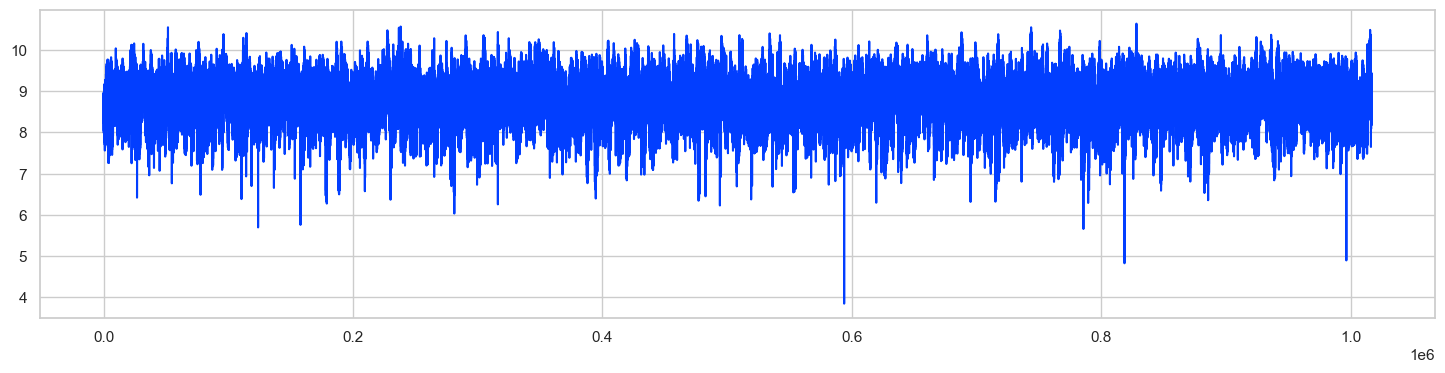

In [246]:
df_ts_train = df_ts_train.fillna(method='bfill').fillna(method='ffill')
df_ts_train['SalesLog'].reset_index(drop=True).plot(figsize=(18,4))

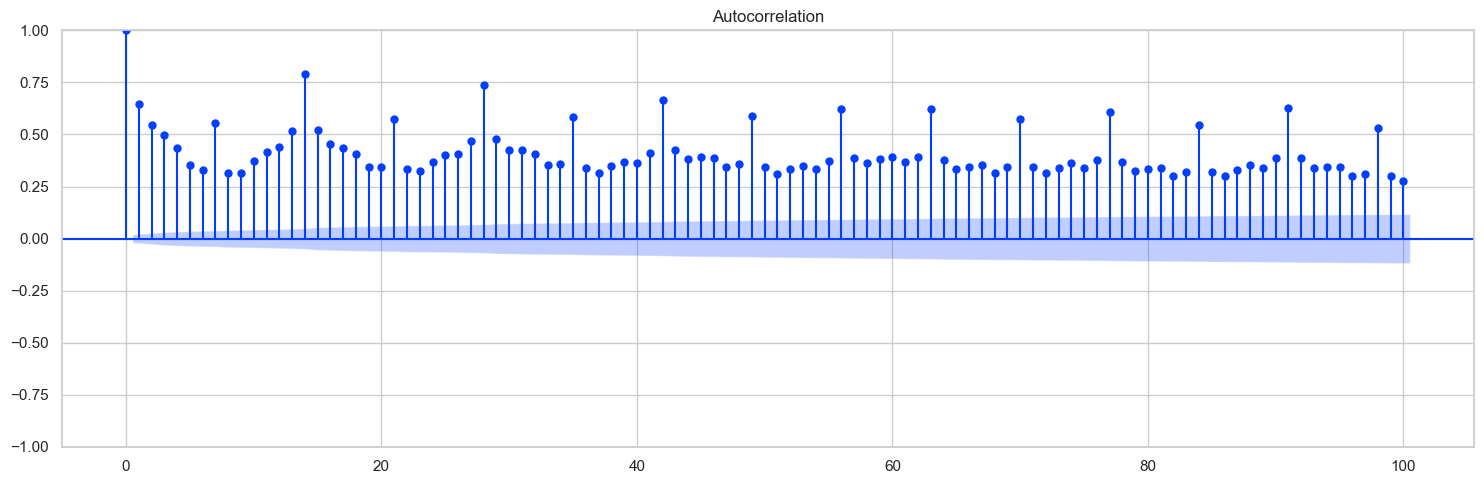

In [247]:
# autocorrelation plot of the dataset
fig = plot_acf(df_ts_train['SalesLog'].iloc[:10000].fillna(method='bfill'), lags=100)
fig.set_size_inches((15, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

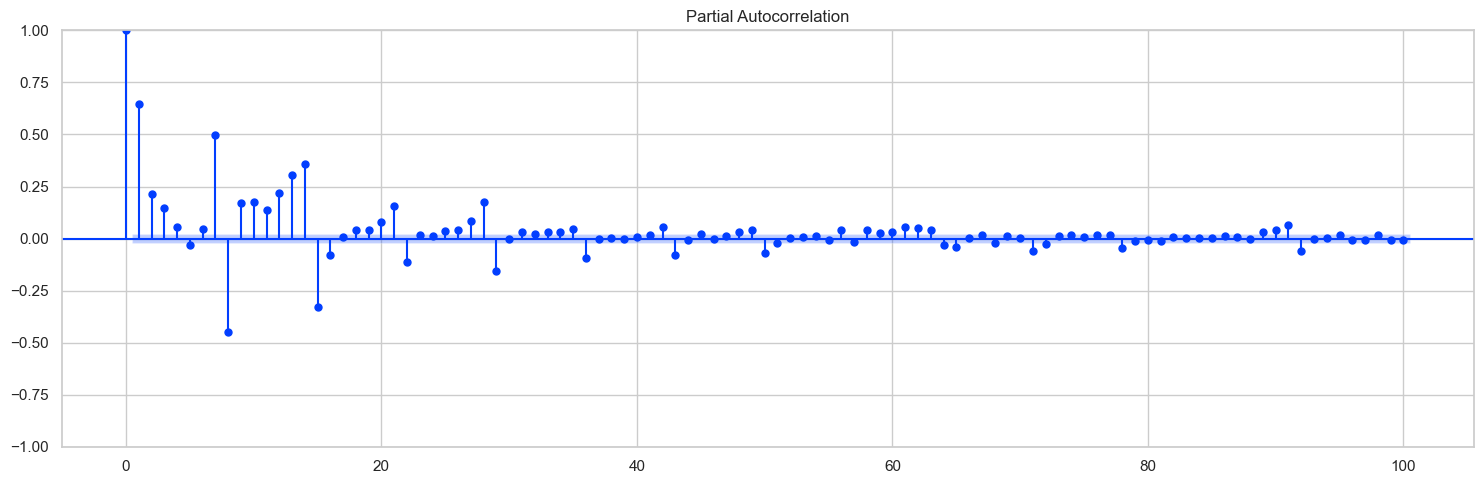

In [248]:
# Partial autocorrelation plot of the dataset
fig = plot_pacf(df_ts_train['SalesLog'].iloc[:10000].fillna(method='bfill'), lags=100)
fig.set_size_inches((15, 5))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### ADF test for stationary time series

In [249]:

X = df_ts_train['SalesLog'].iloc[:10000].fillna(method='bfill').fillna(method='ffill').values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.386816
p-value: 0.000313
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


H0: non stantionary \
H1: stationary \
Running the test prints the test statistic value of -4.5. The more negative this statistic, the more likely we are to reject the null hypothesis (we have a stationary dataset). As part of the output, we get a look-up table to help determine the ADF statistic. We can see that our statistic value of -4.5 is smaller than the value of -2.87 at 5%. Also, the p-value is greater than 0.05. \

This suggests that we reject the null hypothesis with a significance level of 5%. Rejecting the null hypothesis means that that the time series is stationary.

In [293]:
model1 = sm.tsa.ARIMA(df_ts_train['SalesLog'].iloc[-200:], order=(2,1,1))
model1 = model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:               SalesLog   No. Observations:                  200
Model:                 ARIMA(2, 1, 1)   Log Likelihood                  70.335
Date:                Tue, 12 Mar 2024   AIC                           -132.670
Time:                        22:15:00   BIC                           -119.496
Sample:                             0   HQIC                          -127.338
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7745      0.060     12.808      0.000       0.656       0.893
ar.L2         -0.0692      0.070     -0.984      0.325      -0.207       0.069
ma.L1         -0.9804      0.018    -54.685      0.0

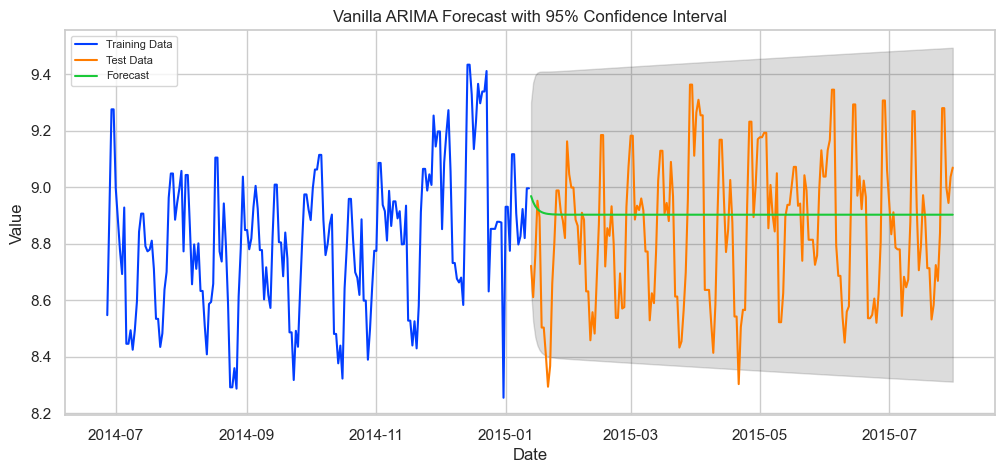

In [295]:
# Forecast
forecast_steps = len(df_ts_val) #1
forecast_values = model1.forecast(steps=forecast_steps)

df_ts_train_last100 = df_ts_train[['Date','SalesLog']].iloc[-200:].fillna(method='bfill').fillna(method='ffill')
df_ts_val_first100 = df_ts_val[['Date','SalesLog']].fillna(method='bfill').fillna(method='ffill')
# Calculate the standard errors of the forecasts
stderr = model1.get_prediction(start=len(df_ts_train_last100), end=len(df_ts_train_last100) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values.values - z_score * stderr.values
upper_bound = forecast_values.values + z_score * stderr.values

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values.values, index=df_ts_val_first100['Date'])
lower_series = pd.Series(lower_bound, index=df_ts_val_first100['Date'])
upper_series = pd.Series(upper_bound, index=df_ts_val_first100['Date'])
df_ts_train_last100_series = pd.Series(df_ts_train_last100['SalesLog'].values, index=df_ts_train_last100['Date'])
df_ts_val_first100_series = pd.Series(df_ts_val_first100['SalesLog'].values, index=df_ts_val_first100['Date'])
# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df_ts_train_last100_series, label='Training Data')
plt.plot(df_ts_val_first100_series , label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Vanilla ARIMA Forecast with 95% Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [303]:
model3 = sm.tsa.ARIMA(df_ts_train['SalesLog'].iloc[-200:], order=(2,1,2), seasonal_order = (1,1,1,7))
model3 = model3.fit()
print(model3.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          SalesLog   No. Observations:                  200
Model:             ARIMA(2, 1, 2)x(1, 1, [1], 7)   Log Likelihood                  58.628
Date:                           Tue, 12 Mar 2024   AIC                           -103.255
Time:                                   22:17:18   BIC                            -80.453
Sample:                                        0   HQIC                           -94.020
                                           - 200                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4195      0.717      0.585      0.559      -0.986       1.825
ar.L2         -0.4607      0.330     -1.397

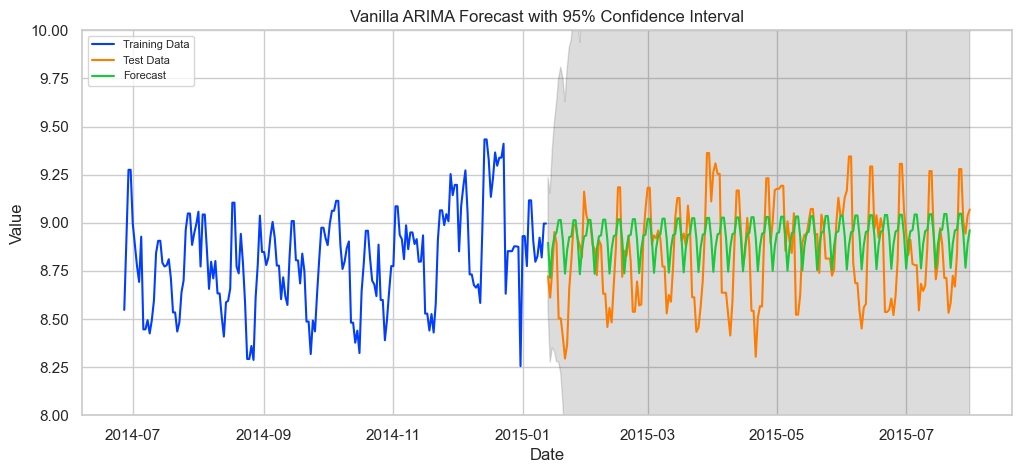

In [304]:
# Forecast
forecast_steps = len(df_ts_val) #1
forecast_values = model3.forecast(steps=forecast_steps)

df_ts_train_last100 = df_ts_train[['Date','SalesLog']].iloc[-200:].fillna(method='bfill').fillna(method='ffill')
df_ts_val_first100 = df_ts_val[['Date','SalesLog']].fillna(method='bfill').fillna(method='ffill')
# Calculate the standard errors of the forecasts
stderr = model3.get_prediction(start=len(df_ts_train_last100), end=len(df_ts_train_last100) + forecast_steps - 1).se_mean

# Calculate lower and upper bounds for a 95% confidence interval
alpha = 0.05
z_score = 1.96  # for a 95% confidence interval
lower_bound = forecast_values.values - z_score * stderr.values
upper_bound = forecast_values.values + z_score * stderr.values

# Create pandas Series for forecasts and intervals
fc_series = pd.Series(forecast_values.values, index=df_ts_val_first100['Date'])
lower_series = pd.Series(lower_bound, index=df_ts_val_first100['Date'])
upper_series = pd.Series(upper_bound, index=df_ts_val_first100['Date'])
df_ts_train_last100_series = pd.Series(df_ts_train_last100['SalesLog'].values, index=df_ts_train_last100['Date'])
df_ts_val_first100_series = pd.Series(df_ts_val_first100['SalesLog'].values, index=df_ts_val_first100['Date'])
# Plot
plt.figure(figsize=(12, 5), dpi=100)
plt.plot(df_ts_train_last100_series, label='Training Data')
plt.plot(df_ts_val_first100_series , label='Test Data')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Seasonal ARIMA Forecast with 95% Confidence Interval')
plt.ylim(8,10)
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [331]:
# Seasonal - fit stepwise auto-ARIMA
smodel = pm.auto_arima(df_ts_train['SalesLog'].iloc[-200:], start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=7,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',
                         suppress_warnings=True,
                         stepwise=True)

smodel.summary()


Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.52 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=152.617, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=-43.725, Time=0.31 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=150.704, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=0.522, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=-80.020, Time=3.26 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=-95.687, Time=6.17 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=-93.836, Time=0.70 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=-94.049, Time=11.20 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=7.29 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=33.888, Time=5.20 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=-93.888, Time=7.40 sec
 ARIMA(1,0,1)(2,1,1)[12] intercept   : AIC=-93.862, Time=7.91 sec
 ARIMA(0,0,1)(2,1,1)[12] intercept   : AIC=-52.

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  200
Model:             SARIMAX(1, 0, 0)x(2, 1, [1], 12)   Log Likelihood                  52.844
Date:                              Tue, 12 Mar 2024   AIC                            -95.687
Time:                                      22:36:04   BIC                            -79.505
Sample:                                           0   HQIC                           -89.131
                                              - 200                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7275      0.048     15.063      0.000       0.633       0.822
ar.S.L12      -0.2459      0.125     -1.962      0.050      -0.491      -0.000
ar.S.L24      -0.2327      0.116     -2.004      0.045      -0.460      -0.005
ma.S.L12      -0.6764      0.114     -5.943      0.000      -0.900      -0.453
sigma2         0.0307      0.003     10.589      0.000       0.025       0.036
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 6.24
Prob(Q):                              0.80   Prob(JB):                         0.04
Heteroskedasticity (H):               1.75   Skew:                            -0.20
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

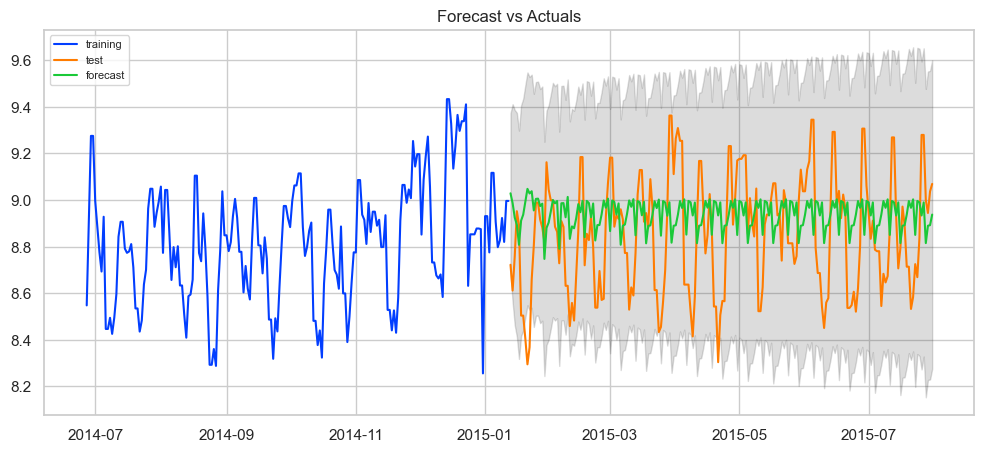

In [332]:
# Forecast
n_periods = len(df_ts_val)
fc_auto_seasonal, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal.values, index=df_ts_val['Date'])
lower_series = pd.Series(confint[:, 0], index=df_ts_val['Date'])
upper_series = pd.Series(confint[:, 1], index=df_ts_val['Date'])

df_ts_val_first100_series = pd.Series(df_ts_val_first100['SalesLog'].values, index=df_ts_val_first100['Date'])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_ts_train_last100_series, label='training')
plt.plot(df_ts_val_first100_series, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Auto Seasonal ARIMA Forecast with 95% Confidence Interval')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [336]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_sarimax = df_ts_train.iloc[-200:]
df_sarimax_endog = df_sarimax['SalesLog']
df_sarimax_exog = df_sarimax[df_sarimax.columns.difference(['Sales', 'SalesLog', 'Customers', 'Date'])].fillna(method='bfill').fillna(method='ffill')
# Fit a SARIMAX model
sxmodel = pm.auto_arima(df_sarimax_endog, exogenous=df_sarimax_exog,
                           start_p=0, start_q=0,
                           test='adf',
                           max_p=2, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

sxmodel.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=inf, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8.699, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-65.656, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.28 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=10.614, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-96.916, Time=0.15 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=-107.692, Time=0.22 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=inf, Time=0.20 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=-105.860, Time=0.59 sec
 ARIMA(1,1,0)(0,1,2)[7]             : AIC=-107.009, Time=0.42 sec
 ARIMA(1,1,0)(2,1,2)[7]             : AIC=inf, Time=0.99 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=-104.165, Time=0.18 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=-106.496, Time=0.35 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=-106.485, Time=0.43 sec

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  200
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood                  58.171
Date:                           Tue, 12 Mar 2024   AIC                           -108.342
Time:                                   22:46:52   BIC                            -95.312
Sample:                                        0   HQIC                          -103.065
                                           - 200                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2054      0.069     -2.963      0.003      -0.341      -0.070
ar.S.L7       -0.2062      0.087     -2.378      0.017      -0.376      -0.036
ma.S.L7       -0.8305      0.084     -9.936      0.000      -0.994      -0.667
sigma2         0.0302      0.002     14.709      0.000       0.026       0.034
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               106.96
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                            -0.82
Prob(H) (two-sided):                  0.08   Kurtosis:                         6.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

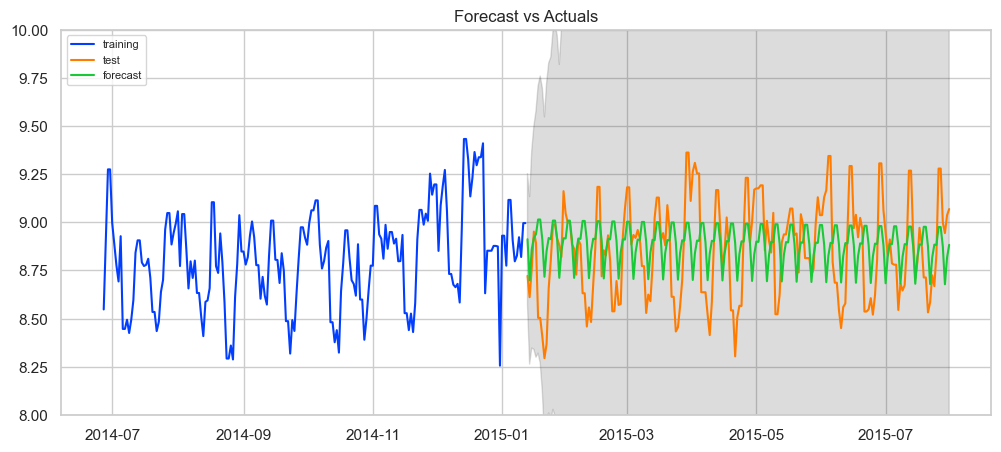

In [339]:
# Forecast
n_periods = len(df_ts_val)
fc_auto_seasonal, confint = sxmodel.predict(n_periods=n_periods, return_conf_int=True)
# make series for plotting purpose
fc_series_auto_seasonal = pd.Series(fc_auto_seasonal.values, index=df_ts_val['Date'])
lower_series = pd.Series(confint[:, 0], index=df_ts_val['Date'])
upper_series = pd.Series(confint[:, 1], index=df_ts_val['Date'])

df_ts_val_first100_series = pd.Series(df_ts_val_first100['SalesLog'].values, index=df_ts_val_first100['Date'])
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_ts_train_last100_series, label='training')
plt.plot(df_ts_val_first100_series, label='test')
plt.plot(fc_series_auto_seasonal, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Auto Seasonal Multivariate ARIMA Forecast with 95% Confidence Interval')
plt.ylim(8,10)
plt.legend(loc='upper left', fontsize=8)
plt.show()